## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

In [1]:
import numpy as np
from collections import deque
import cv2
import glob
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
%matplotlib inline

## 1. Calibrate and Correct for Distortion

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(8,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

./camera_cal/calibration1.jpg
./camera_cal/calibration10.jpg
./camera_cal/calibration11.jpg
./camera_cal/calibration12.jpg
./camera_cal/calibration13.jpg
./camera_cal/calibration14.jpg
./camera_cal/calibration15.jpg
./camera_cal/calibration16.jpg
./camera_cal/calibration17.jpg
./camera_cal/calibration18.jpg
./camera_cal/calibration19.jpg
./camera_cal/calibration2.jpg
./camera_cal/calibration20.jpg
./camera_cal/calibration3.jpg
./camera_cal/calibration4.jpg
./camera_cal/calibration5.jpg
./camera_cal/calibration6.jpg
./camera_cal/calibration7.jpg
./camera_cal/calibration8.jpg
./camera_cal/calibration9.jpg


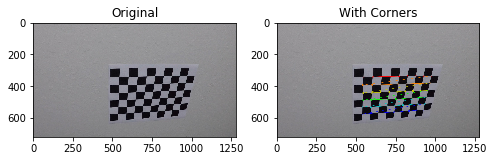

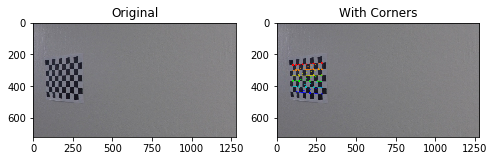

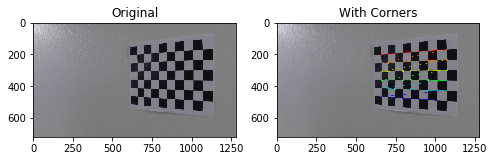

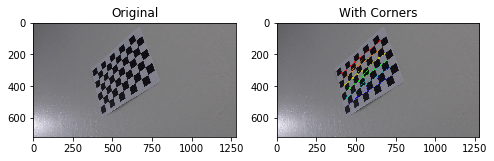

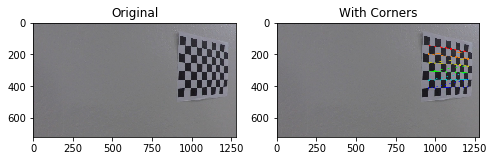

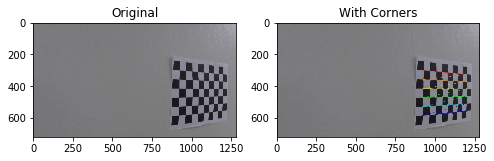

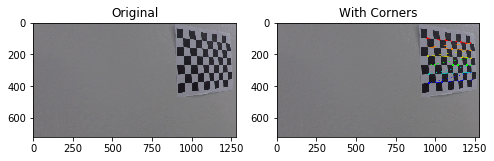

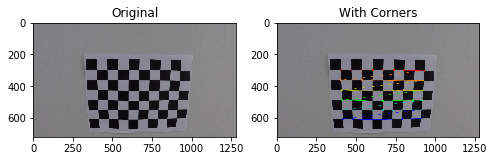

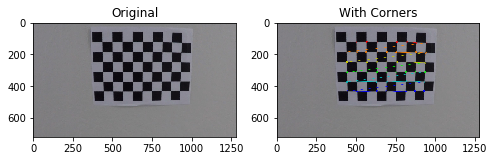

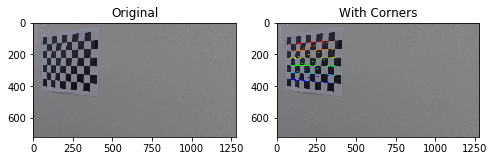

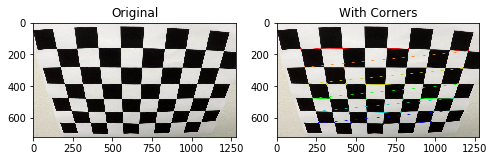

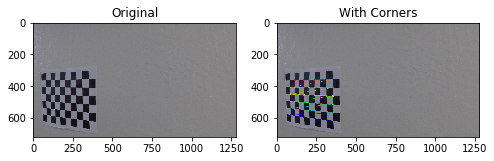

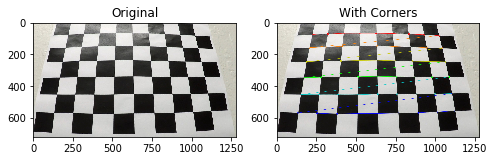

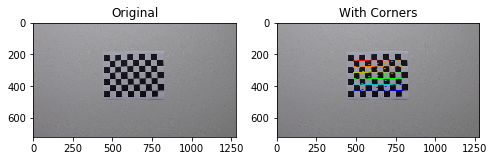

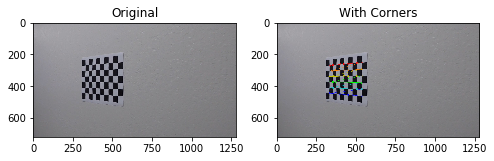

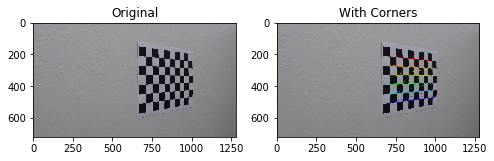

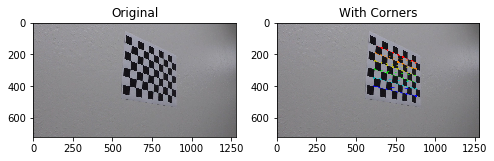

In [3]:
# Step through the list and search for chessboard corners
for fname in images:
    print(fname)
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
 
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
        ax1.imshow(cv2.cvtColor(cv2.imread(fname), cv2.COLOR_BGR2RGB))
        ax1.set_title("Original")
        ax2.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax2.set_title("With Corners")

In [4]:
# define a function to remove distortion from any image based on the objpoints, imgpoints and 
def undistort(image, show=True, read=True):
    if read:
        img = cv2.imread(image)
    img_size = (img.shape[1],img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    if show:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,6))
        ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax1.set_title('Original Image')
        ax2.imshow(cv2.cvtColor(undist, cv2.COLOR_BGR2RGB))
        ax2.set_title('Undistorted Image')
    else:
        return undist

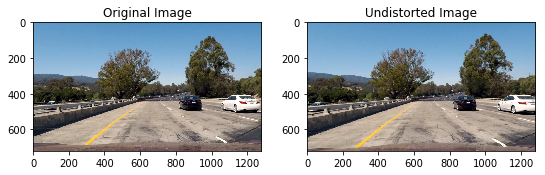

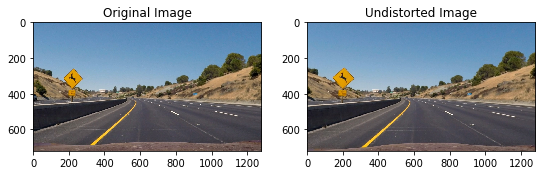

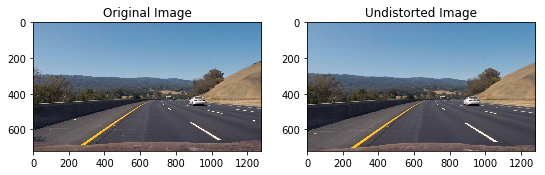

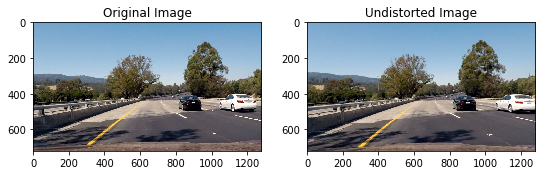

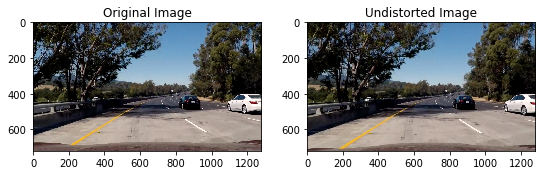

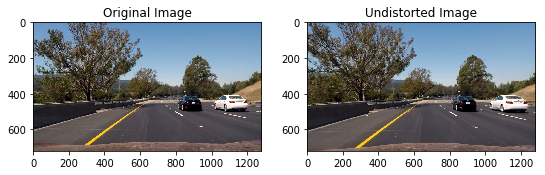

In [5]:
images = glob.glob('test_images/test*.jpg')
for image in images:
    undistort(image)

## 2. Perspective Transform

In [6]:
# Apply perspective transform to show image from top
def warp(image, display=True, read=True):
    if read:
        undist = undistort(image, show=False)
    else:
        undist = undistort(image, show=False, read=False)
    img_size = (undist.shape[1],undist.shape[0])

    src = np.float32([[490, 480],[800, 480],[1180, 640],[170, 640]])
    dst = np.float32([[0,0],[1280,0],[1280,720],[0,720]])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(undist, M, img_size, flags=cv2.INTER_LINEAR)
    
    if display:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 6))
        ax1.imshow(cv2.cvtColor(undist, cv2.COLOR_BGR2RGB))
        ax1.set_title('Undistorted')
        ax2.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
        ax2.set_title('Undistorted and Warped')
    else:
        return warped, M

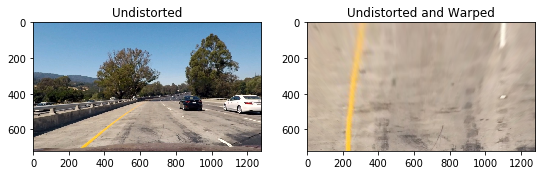

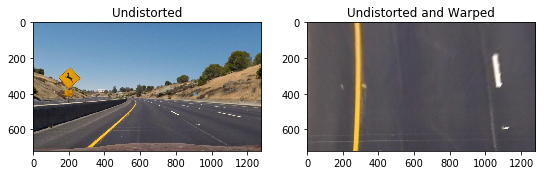

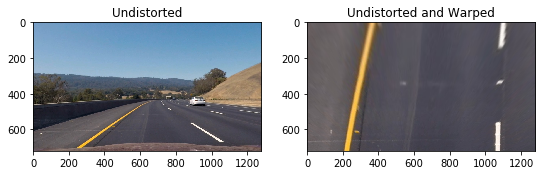

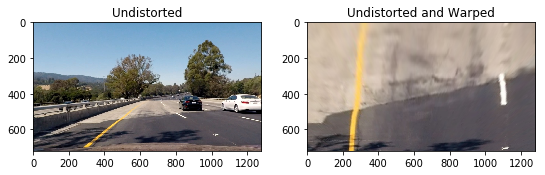

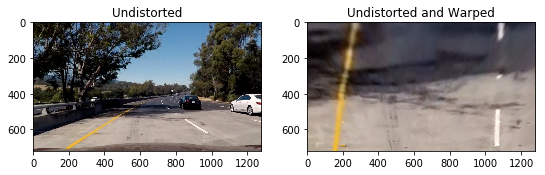

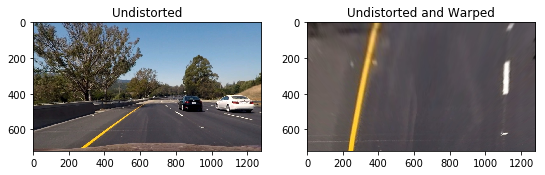

In [7]:
for image in glob.glob('test_images/test*.jpg'):
    warp(image)

## 3. Binary Thresholds

In [8]:
# Apply binary threshold to images to isolate lane line pixels
def apply_binary(image, show=True):
    img, M = warp(image, display=False)
    
    l_channel = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)[:,:,0]
    b_channel = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)[:,:,2]
    
    # Threshold color channel
    l_thresh_min = 225
    l_thresh_max = 255
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh_min) & (l_channel <= l_thresh_max)] = 1
    
    b_thresh_min = 155
    b_thresh_max = 200
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= b_thresh_min) & (b_channel <= b_thresh_max)] = 1
    
    combined_binary = np.zeros_like(l_binary)
    combined_binary[(l_binary == 1) | (b_binary == 1)] = 1
    
    if show:
        f, ((ax1, ax2, ax3), (ax4,ax5, ax6)) = plt.subplots(2, 3, sharey='col', sharex='row', figsize=(10,4))
        
        ax1.set_title('Original Undistorted Image')
        ax1.imshow(cv2.cvtColor(undistort(image, show=False), cv2.COLOR_BGR2RGB))
        
        ax2.set_title('Warped Image')
        ax2.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype('uint8'))
        
        ax5.set_title('l binary threshold')
        ax5.imshow(l_binary, cmap='gray')
        
        ax4.set_title('b binary threshold')
        ax4.imshow(b_binary, cmap='gray')

        ax3.set_title('Combined color thresholds')
        ax3.imshow(combined_binary, cmap='gray')
    
    else:
        return combined_binary

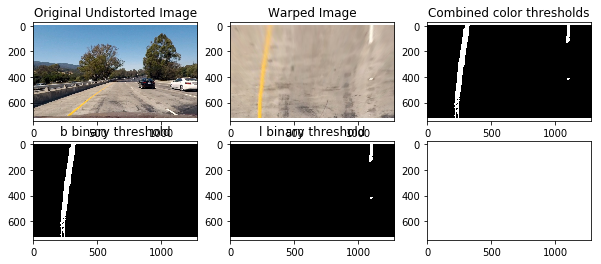

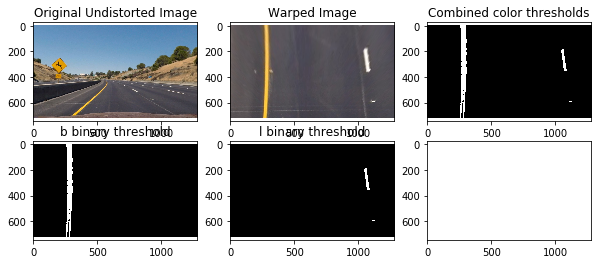

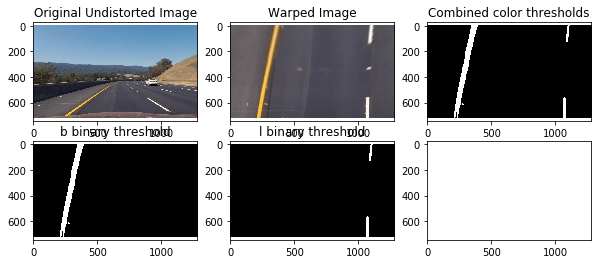

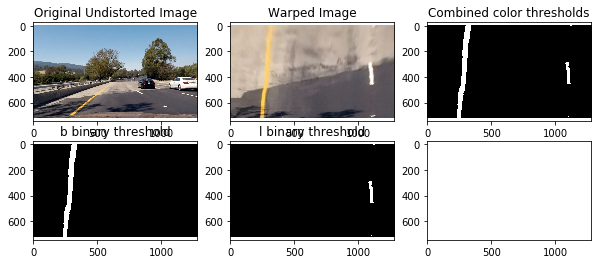

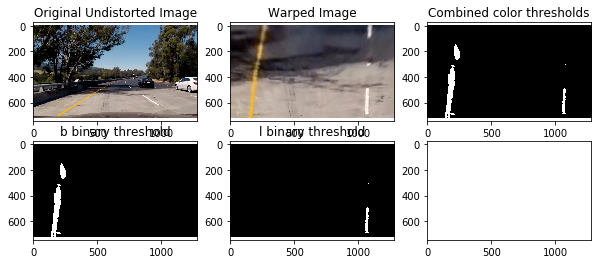

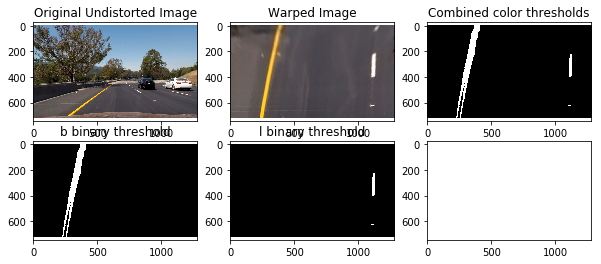

In [9]:
for image in glob.glob('test_images/test*.jpg'):
    apply_binary(image)

## 4. Find Peaks and draw polynomials

In [10]:
def fit_lanes(image, show=True):
    binary = apply_binary(image, show=False)
    
    out_img = np.dstack((binary, binary, binary))*255
    
    histogram = np.sum(binary[binary.shape[0]//2:,:], axis=0)
    midpoint = np.int(histogram.shape[0]//2)
    
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    nwindows = 9
    window_height = np.int(binary.shape[0]/nwindows)
    
    nonzero = binary.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    margin = 100
    minpix = 20
    
    left_lane_inds = []
    right_lane_inds = []
    rectangle_data = []
    
    for window in range(nwindows):
        win_y_low = binary.shape[0] - (window+1)*window_height
        win_y_high = binary.shape[0] - (window)*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        rectangle_data.append((win_y_low, win_y_high, win_xleft_low, win_xleft_high, win_xright_low, win_xright_high))
        
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        if (len(good_left_inds) > minpix):
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if (len(good_right_inds) > minpix):
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_fit = np.polyfit(lefty,leftx,2)
    right_fit = np.polyfit(righty,rightx,2)
    
    visualization_data = (rectangle_data, histogram)
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds, visualization_data, lefty, leftx, righty, rightx


def draw_polynomial(image, show=True):
    left_fit, right_fit, left_lane_inds, right_lane_inds, visualization_data, lefty, leftx, righty, rightx  = fit_lanes(image, show=False)
    
    # find the intercept of y axis
    image_read = cv2.imread(image)
    h = image_read.shape[0]
    left_fitx_int = left_fit[0]*h**2 + left_fit[1]*h + left_fit[2]
    right_fitx_int = right_fit[0]*h**2 + right_fit[1]*h + right_fit[2] 
    
    binary = apply_binary(image, show=False)
    out_img = np.uint8(np.dstack((binary, binary, binary))*255)
    
    # fit left and right polynomials
    ploty = np.linspace(0, binary.shape[0]-1, binary.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    if show:
        rectangles = visualization_data[0]
        histogram = visualization_data[1]

        for rect in rectangles:
            cv2.rectangle(out_img,(rect[2],rect[0]),(rect[3],rect[1]),(0,255,0), 2) 
            cv2.rectangle(out_img,(rect[4],rect[0]),(rect[5],rect[1]),(0,255,0), 2)

        out_img[lefty, leftx] = [255, 0, 0]
        out_img[righty, rightx] = [100, 200, 255]

        f, (ax1, ax2) = plt.subplots(1,2, figsize=(9, 6))

        ax1.imshow(warp(image,display=False)[0])
        ax1.set_xlim(0, 1280)
        ax1.set_ylim(720, 0)
        ax1.plot(left_fitx, ploty, color='yellow', linewidth=3)
        ax1.plot(right_fitx, ploty, color='yellow', linewidth=3)

        ax2.imshow(out_img)
        ax2.set_xlim(0, 1280)
        ax2.set_ylim(720, 0)
        ax2.plot(left_fitx, ploty, color='yellow', linewidth=3)
        ax2.plot(right_fitx, ploty, color='yellow', linewidth=3)
    else:
        return left_fitx, right_fitx, lefty, leftx, righty, rightx, ploty, left_fitx_int, right_fitx_int

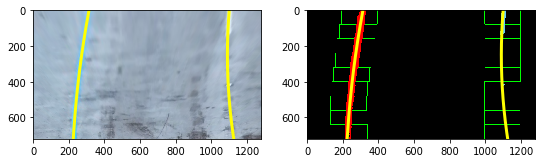

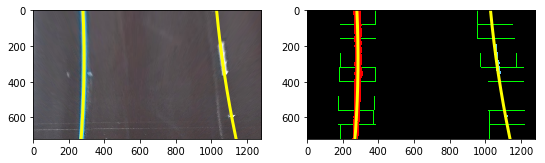

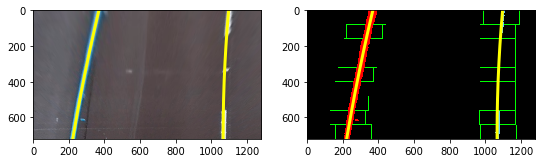

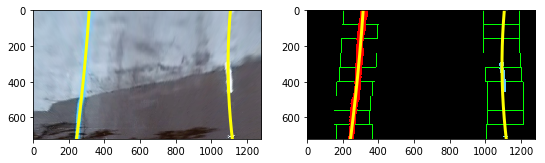

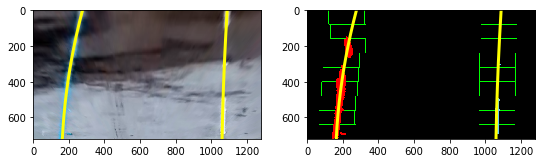

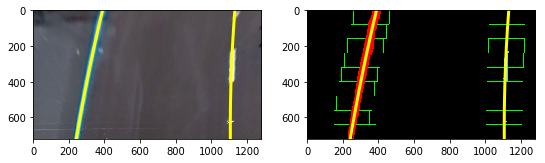

In [11]:
for image in glob.glob('test_images/test*.jpg'):
    draw_polynomial(image)

In [12]:
def fill_lane(image, show=True):
    left_fitx, right_fitx, lefty, leftx, righty, rightx, ploty, left_fitx_int, right_fitx_int = draw_polynomial(image, show=False)
    ymeter = 30./720
    xmeter = 3.7/700

    left_fit = np.polyfit(lefty*ymeter, leftx*xmeter, 2)
    right_fit = np.polyfit(righty*ymeter, rightx*xmeter, 2)
    
    left_curverad = ((1 + (2*left_fit[0]*np.max(lefty) + left_fit[1])**2)**1.5) \
                                 /np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*np.max(lefty) + right_fit[1])**2)**1.5) \
                                    /np.absolute(2*right_fit[0])
    
    binary = apply_binary(image, show=False)
    out_img = np.uint8(np.dstack((binary, binary, binary))*255)
    
    histogram = np.sum(binary[binary.shape[0]//2:,:], axis=0)
    midpoint = np.int(histogram.shape[0]//2)
    
    # Position of vehicle
    center = abs(midpoint - ((right_fitx_int+left_fitx_int)/2))
    
    src = np.float32([[490, 480],[800, 480],[1250, 720],[0, 720]])
    dst = np.float32([[0, 0], [1280, 0],[1280, 720],[40, 720]])
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    binary_zero = np.zeros_like(binary).astype(np.uint8)
    color_warp = np.dstack((binary_zero, binary_zero, binary_zero))
    pts_left = np.array([np.flipud(np.transpose(np.vstack([left_fitx, ploty])))])
    pts_right = np.array([np.transpose(np.vstack([right_fitx, ploty]))])
    pts = np.hstack((pts_left, pts_right))
    
    cv2.polylines(color_warp, np.int_([pts]), isClosed=False, color=(0,0,255), thickness = 40)
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    new_warped_image = cv2.warpPerspective(color_warp, Minv, (binary.shape[1], binary.shape[0]))
    result = cv2.addWeighted(cv2.imread(image), 1, new_warped_image, 0.5, 0)
    
    if show:
        out_img[lefty, leftx] = [255, 0, 0]
        out_img[righty, rightx] = [0, 0, 255]
    
        f, (ax1, ax2) = plt.subplots(1,2, figsize=(9, 6))
        
        ax1.imshow(warp(image,display=False)[0])
        ax1.set_xlim(0, 1280)
        ax1.set_ylim(720, 0)
        ax1.plot(left_fitx, ploty, color='yellow', linewidth=3)
        ax1.plot(right_fitx, ploty, color='yellow', linewidth=3)
        
        ax2.imshow(result)
        ax2.set_title('Fill Lane', fontsize=16)
        ax2.text(20, 100, 'Radius of Curvature = {}m'.format(int((left_curverad + right_curverad)/2)), style='italic', color='white', fontsize=10)
        if center < midpoint:
            ax2.text(20, 175, 'Vehicle is {:.2f}m left of center'.format(center*xmeter), style='italic', color='white', fontsize=10)
        else:
            ax2.text(20, 175, 'Vehicle is {:.2f}m right of center'.format(center*xmeter), style='italic', color='white', fontsize=10)
        

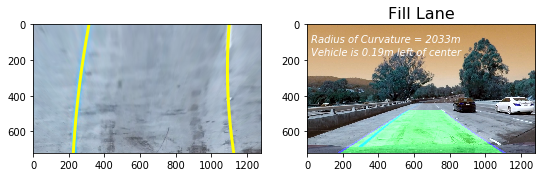

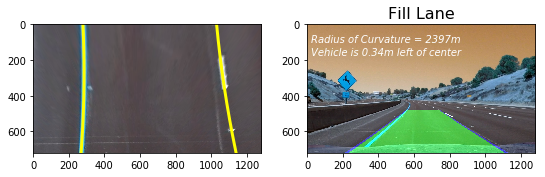

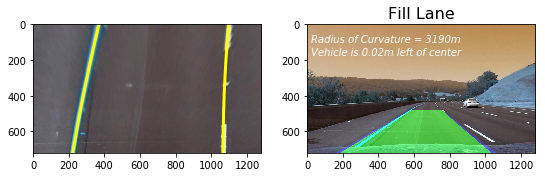

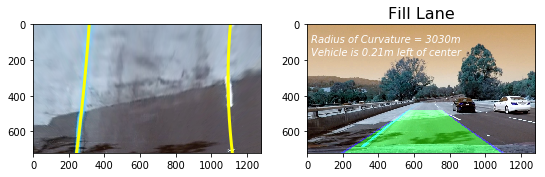

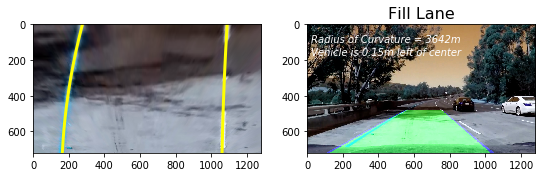

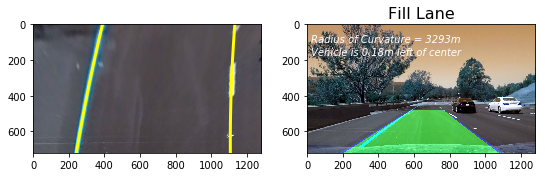

In [13]:
for image in glob.glob('test_images/test*.jpg'):
    fill_lane(image)

## 5. Video Processing

In [14]:
class Line:
    def __init__(self):
        # was a line detected in the previous frame?
        self.found = False
        
        # x and y values of lanes in previous frame
        self.X = None
        self.Y = None
        
        # recent x intercepts for averaging across frames
        self.x_int = deque(maxlen=10)
        self.top = deque(maxlen=10)
        
        # previous x intercept to compare against current one
        self.lastx_int = None
        self.last_top = None
        
        # radius of curvature
        self.radius = None
        
        # recent polynomial coefficients for averaging across frames
        self.fit0 = deque(maxlen=10)
        self.fit1 = deque(maxlen=10)
        self.fit2 = deque(maxlen=10)
        self.fitx = None
        self.pts = []
        
        # number of frames
        self.count = 0
        
    
    # lane lines have been detected in previous frame
    def known_lanes_search(self, x, y):
        xvals = []
        yvals = []
        if self.found == True: 
            i = 720
            j = 640
            while j >= 0:
                yval = np.mean([i,j])
                xval = (np.mean(self.fit0))*yval**2 + (np.mean(self.fit1))*yval + (np.mean(self.fit2))
                x_idx = np.where((((xval - 25) < x)&(x < (xval + 25))&((y > j) & (y < i))))
                x_window, y_window = x[x_idx], y[x_idx]
                if np.sum(x_window) != 0:
                    np.append(xvals, x_window)
                    np.append(yvals, y_window)
                i -= 90
                j -= 90
        if np.sum(xvals) == 0: 
            self.found = False # If no lane pixels were detected then perform blind search
        return xvals, yvals, self.found
    
    
    # lane lines have not been detected in previous frame / or applied to first frames
    def blind_search(self, x, y, image):
        xvals = []
        yvals = []
        if self.found == False: 
            i = 720
            j = 640
            while j >= 0:
                histogram = np.sum(image[j:i,:], axis=0)
                if self == Right:
                    peak = np.argmax(histogram[640:]) + 640
                else:
                    peak = np.argmax(histogram[:640])
                x_idx = np.where((((peak - 25) < x)&(x < (peak + 25))&((y > j) & (y < i))))
                x_window, y_window = x[x_idx], y[x_idx]
                if np.sum(x_window) != 0:
                    xvals.extend(x_window)
                    yvals.extend(y_window)
                i -= 90
                j -= 90
        if np.sum(xvals) > 0:
            self.found = True
        else:
            yvals = self.Y
            xvals = self.X
        return xvals, yvals, self.found
    
    def radius_of_curvature(self, xvals, yvals):
        ymeter = 30./720 # meters per pixel in y dimension
        xmeter = 3.7/700 # meters per pixel in x dimension
        fit = np.polyfit(yvals*ymeter, xvals*xmeter, 2)
        curverad = ((1 + (2*fit[0]*np.max(yvals) + fit[1])**2)**1.5) \
                                     /np.absolute(2*fit[0])
        return curverad
    
    def sort_vals(self, xvals, yvals):
        sorted_index = np.argsort(yvals)
        sorted_yvals = yvals[sorted_index]
        sorted_xvals = xvals[sorted_index]
        return sorted_xvals, sorted_yvals
    
    def get_intercepts(self, polynomial):
        bottom = polynomial[0]*720**2 + polynomial[1]*720 + polynomial[2]
        top = polynomial[0]*0**2 + polynomial[1]*0 + polynomial[2]
        return bottom, top

In [15]:
def process_vid(image):
    img_size = (image.shape[1], image.shape[0])
    
    # calibrate camera and undistort image based on object- and image-points from checkboard images
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    
    # apply perspective transform
    offset = 0
    src = np.float32([[490, 480],[800, 480],[1250, 720],[0, 720]])
    dst = np.float32([[0, 0], [1280, 0],[1280, 720],[40, 720]])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(undist, M, img_size)
    
    # generate binary images (only using two color channels because they detect left and right lanes really well)
    b_channel = cv2.cvtColor(warped, cv2.COLOR_RGB2Lab)[:,:,2]
    l_channel = cv2.cvtColor(warped, cv2.COLOR_RGB2LUV)[:,:,0]  
    
    # thresholds for b channel
    b_thresh_min = 145
    b_thresh_max = 200
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= b_thresh_min) & (b_channel <= b_thresh_max)] = 1
    
    # thresholds for l channel
    l_thresh_min = 215
    l_thresh_max = 255
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh_min) & (l_channel <= l_thresh_max)] = 1

    # combine both binaries
    combined_binary = np.zeros_like(b_binary)
    combined_binary[(l_binary == 1) | (b_binary == 1)] = 1
    
    # identify all non zero pixels in the image
    x, y = np.nonzero(np.transpose(combined_binary)) 

    # search for left lane pixels
    if Left.found == True: 
        leftx, lefty, Left.found = Left.known_lanes_search(x, y)
        
    # search for right lane pixels
    if Right.found == True: 
        rightx, righty, Right.found = Right.known_lanes_search(x, y)

    # search for right lane pixels if not previously found   
    if Right.found == False:
        rightx, righty, Right.found = Right.blind_search(x, y, combined_binary)
     
    # search for left lane pixels if not previously found
    if Left.found == False:
        leftx, lefty, Left.found = Left.blind_search(x, y, combined_binary)

    lefty = np.array(lefty).astype(np.float32)
    leftx = np.array(leftx).astype(np.float32)
    righty = np.array(righty).astype(np.float32)
    rightx = np.array(rightx).astype(np.float32)
            
    # calculate left polynomial fit based on detected pixels
    left_fit = np.polyfit(lefty, leftx, 2)
    leftx_int, left_top = Left.get_intercepts(left_fit)
    
    # Average intercepts across n frames
    Left.x_int.append(leftx_int)
    Left.top.append(left_top)
    leftx_int = np.mean(Left.x_int)
    left_top = np.mean(Left.top)
    Left.lastx_int = leftx_int
    Left.last_top = left_top
    
    # Add averaged intercepts to current x and y vals
    leftx = np.append(leftx, leftx_int)
    lefty = np.append(lefty, 720)
    leftx = np.append(leftx, left_top)
    lefty = np.append(lefty, 0)
    
    leftx, lefty = Left.sort_vals(leftx, lefty)
    
    Left.X = leftx
    Left.Y = lefty
    
    # recalculate polynomial with intercepts and average across n frames
    left_fit = np.polyfit(lefty, leftx, 2)
    Left.fit0.append(left_fit[0])
    Left.fit1.append(left_fit[1])
    Left.fit2.append(left_fit[2])
    left_fit = [np.mean(Left.fit0), 
                np.mean(Left.fit1), 
                np.mean(Left.fit2)]
    
    # fit polynomial to detected pixels
    left_fitx = left_fit[0]*lefty**2 + left_fit[1]*lefty + left_fit[2]
    Left.fitx = left_fitx
    
    # calculate right polynomial fit based on detected pixels
    right_fit = np.polyfit(righty, rightx, 2)
    rightx_int, right_top = Right.get_intercepts(right_fit)
    
    # average intercepts across 5 frames
    Right.x_int.append(rightx_int)
    rightx_int = np.mean(Right.x_int)
    Right.top.append(right_top)
    right_top = np.mean(Right.top)
    Right.lastx_int = rightx_int
    Right.last_top = right_top
    rightx = np.append(rightx, rightx_int)
    righty = np.append(righty, 720)
    rightx = np.append(rightx, right_top)
    righty = np.append(righty, 0)
    
    rightx, righty = Right.sort_vals(rightx, righty)
    Right.X = rightx
    Right.Y = righty
    
    # recalculate polynomial with intercepts and average across n frames
    right_fit = np.polyfit(righty, rightx, 2)
    Right.fit0.append(right_fit[0])
    Right.fit1.append(right_fit[1])
    Right.fit2.append(right_fit[2])
    right_fit = [np.mean(Right.fit0), np.mean(Right.fit1), np.mean(Right.fit2)]
    
    # fit polynomial to detected pixels
    right_fitx = right_fit[0]*righty**2 + right_fit[1]*righty + right_fit[2]
    Right.fitx = right_fitx
       
    # compute radius of curvature
    left_curverad = Left.radius_of_curvature(leftx, lefty)
    right_curverad = Right.radius_of_curvature(rightx, righty)
        
    # only print the radius of curvature every 3 frames for improved readability
    if Left.count % 3 == 0:
        Left.radius = left_curverad
        Right.radius = right_curverad
        
    # calculate the vehicle position relative to the center of the lane
    position = (rightx_int+leftx_int)/2
    distance_from_center = abs((640 - position)*3.7/700) 
                
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    warp_zero = np.zeros_like(combined_binary).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    pts_left = np.array([np.flipud(np.transpose(np.vstack([Left.fitx, Left.Y])))])
    pts_right = np.array([np.transpose(np.vstack([right_fitx, Right.Y]))])
    pts = np.hstack((pts_left, pts_right))
    cv2.polylines(color_warp, np.int_([pts]), isClosed=False, color=(0,0,255), thickness = 40)
    cv2.fillPoly(color_warp, np.int_(pts), (34,255,34))
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0]))
    result = cv2.addWeighted(undist, 1, newwarp, 0.5, 0)
        
    
    # add radius of curvature
    cv2.putText(result, 'Radius of Curvature = {}(m)'.format(int((Left.radius+Right.radius)/2)), (120,140), fontFace=cv2.FONT_HERSHEY_PLAIN, fontScale = 2, color=(255,255,255), thickness = 2)
    
    # add distance from center
    if position > 640:
        cv2.putText(result, 'Vehicle is {:.2f}m left of center'.format(distance_from_center), (100,80), fontFace=cv2.FONT_HERSHEY_PLAIN, fontScale = 2, color=(255,255,255), thickness = 2)
    else:
        cv2.putText(result, 'Vehicle is {:.2f}m right of center'.format(distance_from_center), (100,80), fontFace=cv2.FONT_HERSHEY_PLAIN, fontScale = 2, color=(255,255,255), thickness = 2)

    Left.count += 1
    return result

In [16]:
Left = Line()
Right = Line()
video_output = 'result.mp4'
clip1 = VideoFileClip("test_videos/project_video.mp4")
video_clip = clip1.fl_image(process_vid) 
video_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video result.mp4
[MoviePy] Writing video result.mp4


100%|█████████▉| 1260/1261 [18:15<00:00,  1.18it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result.mp4 



In [17]:
Left = Line()
Right = Line()
challenge_output = 'challenge_result.mp4'
clip2 = VideoFileClip("test_videos/challenge_video.mp4")
challenge_clip = clip2.fl_image(process_vid) 
challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video challenge_result.mp4
[MoviePy] Writing video challenge_result.mp4


100%|██████████| 485/485 [06:28<00:00,  1.27it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_result.mp4 

